In [1]:
import glob
import os
import librosa
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
%matplotlib inline

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical 
import seaborn as sns


from scipy.io import wavfile as wav
import struct
import IPython.display as ipd

plt.style.use('ggplot')

In [2]:
# constants

NP_TRAIN_DATASET = 'dataset_train.npy'
NP_TEST_DATASET = 'dataset_test.npy'
DATA_PATH = "../../../datasets/FSD50K/"
#DATA_PATH = "../../../data_sets/FSD50K/"
DEV_AUDIO_DATASET_PATH = "dev_audio/"
EVAL_AUDIO_DATASET_PATH = "eval_audio/"
TRAIN_CSV = 'train_df.csv'
TEST_CSV = 'test_df.csv'

In [3]:
#load data
train_df = pd.read_csv(TRAIN_CSV, sep=';')
test_df = pd.read_csv(TEST_CSV, sep=';')
train_path = os.path.join(DATA_PATH, DEV_AUDIO_DATASET_PATH)
test_path = os.path.join(DATA_PATH, EVAL_AUDIO_DATASET_PATH)


print("Number of training examples: %d"%(train_df.shape[0]))
print("Number of tesing examples: %d"%(test_df.shape[0]))
print("Number of Classes: %d"%(train_df.labels.nunique()))
print("Classes: ",train_df.labels.unique())

Number of training examples: 39566
Number of tesing examples: 9897
Number of Classes: 262
Classes:  ['Electric_guitar' 'Coin_(dropping)' 'Vehicle_horn' 'Raindrop'
 'Motorcycle' 'Male_speech' 'Traffic_noise' 'Chatter' 'Car_passing_by'
 'Motor_vehicle_(road)' 'Siren' 'Bark' 'Alarm' 'Idling' 'Glass'
 'Waterfall' 'Water' 'Bird' 'Stream' 'Duck' 'Boiling' 'Rain' 'Dishes'
 'Drip' 'Shatter' 'Squeak' 'Speech' 'Babbling' 'Sink_(filling_or_washing)'
 'Clapping' 'Child_speech' 'Applause' 'Alarm_clock' 'Buzzer' 'Truck'
 'Clock' 'Car' 'Bell' 'Howl' 'Tick-tock' 'Keys_jangling' 'Subway' 'Buzz'
 'Door' 'Fart' 'Female_speech' 'Writing' 'Wind_chime' 'Guitar'
 'Steel_guitar' 'Hands' 'Wind' 'Chirp' 'Cricket' 'Tick' 'Ocean' 'Rattle'
 'Sneeze' 'Thunder' 'Bird_flight' 'Owl' 'Gunshot' 'Fireworks' 'Fire'
 'Machine_gun' 'Cap_gun' 'Explosion' 'Keyboard_(musical)' 'Piano'
 'Ringtone' 'Tap' 'Bass_drum' 'Hi-hat' 'Burst' 'Hiss' 'Jingle_bell'
 'Tambourine' 'Typewriter' 'Engine' 'Light_engine_(high_frequency)'
 'Lawn_m

labels
Accordion             52
Acoustic_guitar      459
Air_conditioning      17
Aircraft              33
Alarm                274
                    ... 
Wood                 131
Writing              250
Yawn                  36
Yell                  79
Zipper_(clothing)    288
Length: 262, dtype: int64


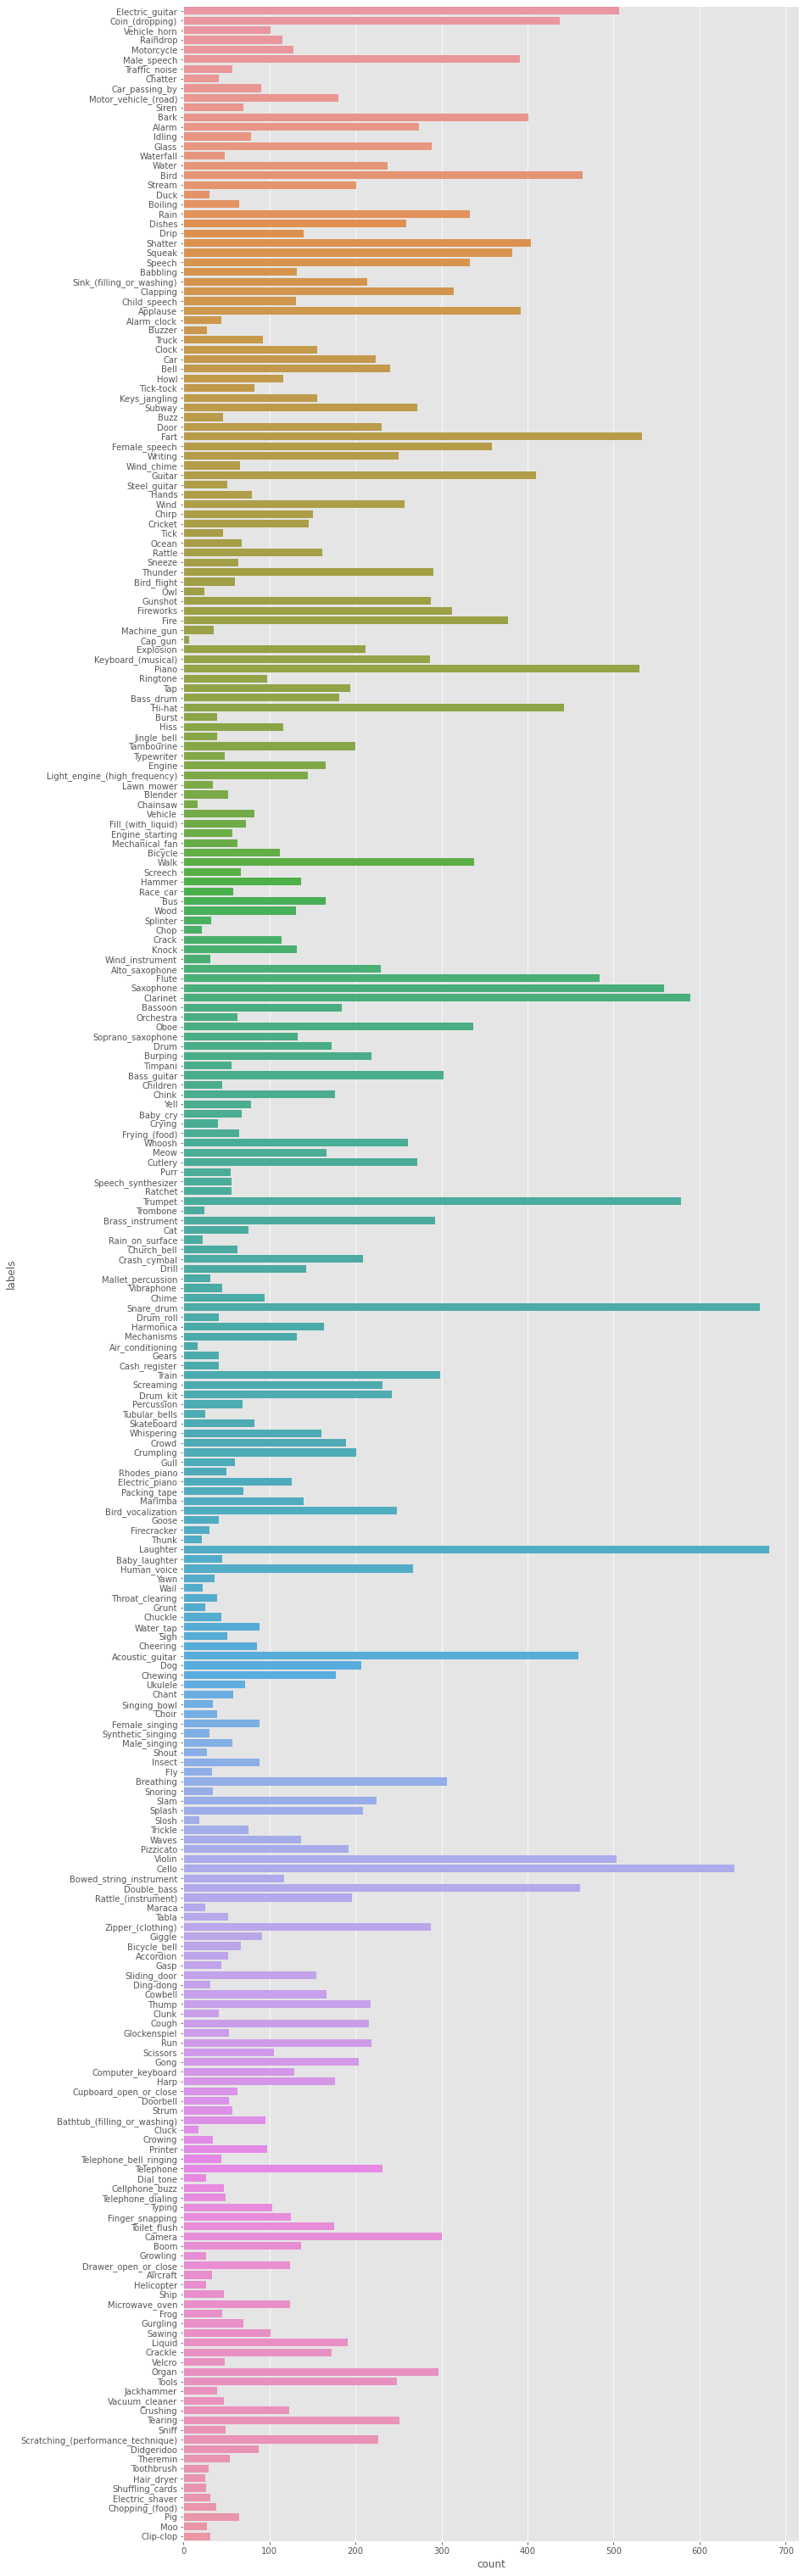

In [33]:
print(train_df.groupby('labels').size())
plt.figure(figsize=(13,55))
sns.countplot(y="labels", data=train_df)
plt.savefig('distribution.png')

In [4]:
print(train_df.head())
print(test_df.head())

   Unnamed: 0  fname           labels      mids
0           0  64760  Electric_guitar  /m/02sgy
1           1  16399  Electric_guitar  /m/02sgy
2           2  16401  Electric_guitar  /m/02sgy
3           3  16402  Electric_guitar  /m/02sgy
4           4  16404  Electric_guitar  /m/02sgy
   Unnamed: 0   fname           labels      mids
0           0   37199  Electric_guitar  /m/02sgy
1           1  175151  Electric_guitar  /m/02sgy
2           2  253463  Electric_guitar  /m/02sgy
3           3  329838  Electric_guitar  /m/02sgy
4           4    1277  Electric_guitar  /m/02sgy


Minimum samples per category =  7


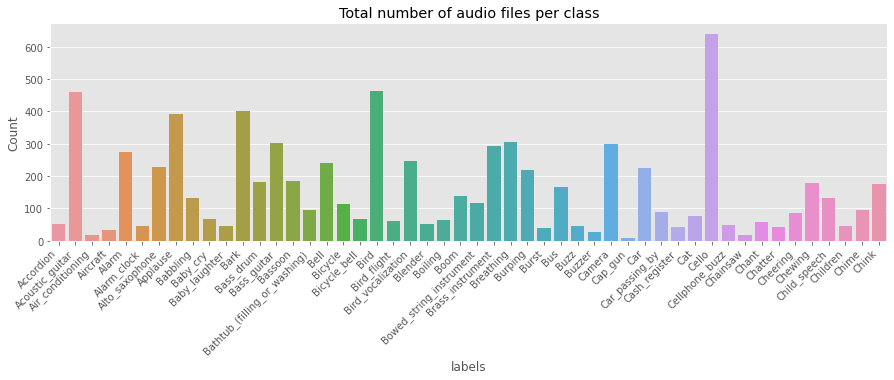

In [5]:
plt.figure(figsize=(15,4))
labels_grouped = train_df.groupby(by=['labels'], ).count().head(50)
chart = sns.barplot(x=labels_grouped.index, y=labels_grouped['fname'])
chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right');
chart.set_title("Total number of audio files per class");
chart.set_ylabel('Count');
print('Minimum samples per category = ', min(train_df['labels'].value_counts()))


In [6]:
# Read wav file function
def path_class(filename, dataset, path):
    excerpt = dataset[dataset['fname'] == int(filename)]
    path_name = os.path.join(path, str(filename) + '.wav')
    return path_name, excerpt['labels'].values[0]

In [7]:
# Drawing wav function
def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape)
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  (75601,)
duration:  1.7143083900226757  second
number of samples:  75601
class:  Electric_guitar


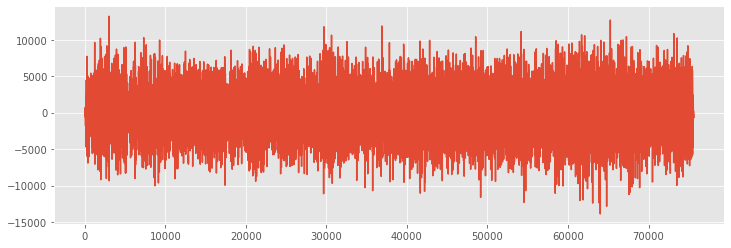

In [8]:
# Give an example of sound to show
fullpath, label = path_class('64760', train_df, train_path)
wav_plotter(fullpath,label)

In [9]:
def numpydataset(data, path):
    dataset = np.zeros(shape = (data.shape[0],6),dtype = object)
    print(dataset.shape) # dataset is the array in which value will be saved
    for i in range(data.shape[0]):
        #print(data.shape[0])
        #print(data.fname[i])
        fullpath, class_id = path_class(data.fname[i], data, path)
        try:
            X, sample_rate = librosa.load(fullpath, res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            stft = np.abs(librosa.stft(X))
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)

        except Exception:
            print("Error encountered while parsing file", fullpath)
            mfccs, chroma, mel, contrast, tonnetz, class_id = None, None, None, None, None, None
        label = class_id
        dataset[i,0],dataset[i,1], dataset[i,2], dataset[i,3], dataset[i,4], dataset[i,5]= mfccs, chroma, mel, contrast, tonnetz, label
    return dataset

In [10]:
train_numpy_dataset = numpydataset(train_df, train_path)
np.save("dataset_train", train_numpy_dataset, allow_pickle=True)

(39566, 6)


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequen

In [11]:
test_numpy_dataset = numpydataset(test_df, test_path)
np.save("dataset_test", test_numpy_dataset, allow_pickle=True)

(9897, 6)


/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequen

In [12]:
l_train = np.load(NP_TRAIN_DATASET,allow_pickle= True)
l_test = np.load(NP_TEST_DATASET,allow_pickle= True)

In [13]:
print(l_train.shape)
print(l_test.shape)

(39566, 6)
(9897, 6)
